<a href="https://colab.research.google.com/github/Max-JI64/Kakao_Tech_Bootcamp/blob/main/Assignment/week7/7%EC%A3%BC%EC%B0%A8%EA%B3%BC%EC%A0%9C4_max_ji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리

In [ ]:
!pip install scikeras
!pip install -U "scikit-learn==1.5.2" "scikeras==0.13.0"

In [ ]:
!python -c "import sklearn, scikeras, tensorflow as tf; print('sklearn', sklearn.__version__, 'scikeras', scikeras.__version__, 'tf', tf.__version__)"

2025-11-03 05:21:55.360342: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-03 05:21:55.380017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762147315.404322    1295 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762147315.410778    1295 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762147315.427090    1295 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
import os, time, math, random, numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier
from scipy.stats import loguniform
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if not gpus:
    raise RuntimeError("GPU가 감지되지 않았습니다. GPU 환경에서 실행하세요.")
for g in gpus:
    tf.config.experimental.set_memory_growth(g, True)
print(f"GPU OK: {[d.name for d in gpus]}")

GPU OK: ['/physical_device:GPU:0']


# 데이터셋

CIFAR-10 사용

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = y_train.ravel(); y_test = y_test.ravel()

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

x_tr, x_val, y_tr, y_val = train_test_split(
    x_train, y_train, test_size=0.15, random_state=SEED, stratify=y_train
)

# 사용 모델

In [ ]:
num_classes = 10 #CIFAR-10 클래스
EPOCHS_TUNE = 15 #튜닝 시 에포크 가볍게
EPOCHS_FINAL = 30 #최적 조합 에포크
PATIENCE = 5 #개선 없을 시 이른 중단

사용할 작은 CNN 모델 정의

In [ ]:
def build_cifar10_sequential(hidden_units=256, lr=1e-3):
    model = keras.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.GlobalAveragePooling2D(),

        layers.Dense(hidden_units, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax"),
    ])
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

SciKeras용 분류기 래퍼

In [ ]:
base_clf = KerasClassifier(
    model=build_cifar10_sequential,
    epochs=EPOCHS_TUNE,
    batch_size=128, #튜닝 때 바꿀꺼지만 현재 임의로 지정
    verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True)]
)

# I. GridSearch

In [ ]:
grid_params = {
    "model__lr": [1e-3, 5e-4],
    "batch_size": [64, 128],
    "model__hidden_units": [128, 256, 512],
}
n_candidates_grid = len(grid_params["model__lr"]) * len(grid_params["batch_size"]) * len(grid_params["model__hidden_units"])

grid_search = GridSearchCV(
    estimator=base_clf,
    param_grid=grid_params,
    scoring="accuracy",
    cv=3,
    refit=True
)


In [ ]:
#그리드서치, 랜덤서치 결과 저장
metrics_summary = []

## 학습

In [ ]:
t0 = time.time()
grid_search.fit(x_train, y_train)
t_grid = time.time() - t0

best_grid_params = grid_search.best_params_
best_grid_score  = grid_search.best_score_
metrics_summary.append({
    "튜닝종류": "GridSearch",
    "시도횟수": n_candidates_grid,
    "걸린시간(초)": round(t_grid, 2),
    "최적조합": best_grid_params,
    "CV최고정확도": round(best_grid_score, 4)
})


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/p

## 최적 조합

In [ ]:
def train_with_history(params, label):
    # params: {"model__lr":..., "batch_size":..., "model__hidden_units":...}
    lr = params["model__lr"]
    bs = params["batch_size"]
    hu = params["model__hidden_units"]

    model = build_cifar10_sequential(hidden_units=hu, lr=lr)

    history = model.fit(
        x_tr, y_tr,
        validation_data=(x_val, y_val),
        epochs=EPOCHS_FINAL,
        batch_size=bs,
        verbose=0,
        callbacks=[keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True)]
    )
    # 최종 테스트 성능
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    return model, history.history, {"테스트정확도": float(test_acc), "테스트손실": float(test_loss)}, label


In [ ]:
grid_model, grid_hist, grid_test_metrics, _ = train_with_history(best_grid_params, "GridSearch Best")

# II. RandomSearch

In [ ]:
rand_params = {
    "model__lr": loguniform(1e-4, 1e-3),
    "batch_size": [64, 96, 128, 160],
    "model__hidden_units": [128, 256, 384, 512],
}
N_ITER_RANDOM = 12

rand_search = RandomizedSearchCV(
    estimator=base_clf,
    param_distributions=rand_params,
    n_iter=N_ITER_RANDOM,
    scoring="accuracy",
    cv=3,
    n_jobs=1,
    refit=True,
    random_state=SEED
)

## 학습

In [ ]:
t0 = time.time()
rand_search.fit(x_train, y_train)
t_rand = time.time() - t0

best_rand_params = rand_search.best_params_
best_rand_score  = rand_search.best_score_
metrics_summary.append({
    "튜닝종류": "RandomizedSearch",
    "시도횟수": N_ITER_RANDOM,
    "걸린시간(초)": round(t_rand, 2),
    "최적조합": best_rand_params,
    "CV최고정확도": round(best_rand_score, 4)
})

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/p

## 최적 조합

In [ ]:
rand_model, rand_hist, rand_test_metrics, _ = train_with_history(best_rand_params, "RandomizedSearch Best")

# 결과 비교

## 성능 비교표

In [ ]:
compare_rows = []
compare_rows.append({
    "튜닝종류": "GridSearch",
    "시도횟수": n_candidates_grid,
    "총소요시간(초)": round(t_grid, 2),
    # "최적조합": best_grid_params,
    "CV최고정확도": round(best_grid_score, 4),
    "테스트정확도": round(grid_test_metrics["테스트정확도"], 4),
    "테스트손실": round(grid_test_metrics["테스트손실"], 4),
})
compare_rows.append({
    "튜닝종류": "RandomizedSearch",
    "시도횟수": N_ITER_RANDOM,
    "총소요시간(초)": round(t_rand, 2),
    # "최적조합": best_rand_params,
    "CV최고정확도": round(best_rand_score, 4),
    "테스트정확도": round(rand_test_metrics["테스트정확도"], 4),
    "테스트손실": round(rand_test_metrics["테스트손실"], 4),
})
compare_df = pd.DataFrame(compare_rows).T
print("\n=== 성능 비교표 ===")
compare_df


=== 성능 비교표 ===


,0,1
튜닝종류,GridSearch,RandomizedSearch
시도횟수,12,12
총소요시간(초),1327.45,1251.03
CV최고정확도,0.7475,0.7239
테스트정확도,0.7741,0.7927
테스트손실,0.723,0.6668


In [ ]:
print(f"GridSearch 최적 조합 : {best_grid_params}")
print(f"RandomizedSearch 최적 조합 : {best_rand_params}")

GridSearch 최적 조합 : {'batch_size': 64, 'model__hidden_units': 256, 'model__lr': 0.001}
RandomizedSearch 최적 조합 : {'batch_size': 96, 'model__hidden_units': 128, 'model__lr': np.float64(0.0009330606024425672)}


## 학습 곡선

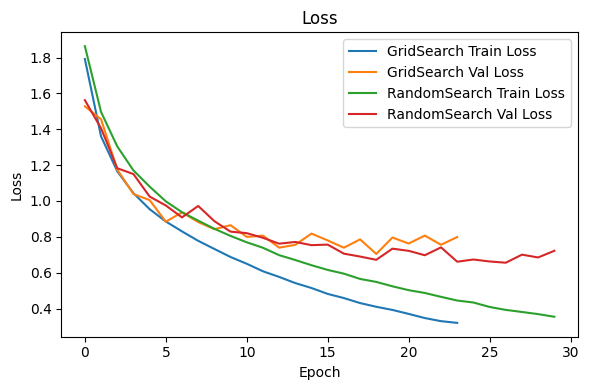

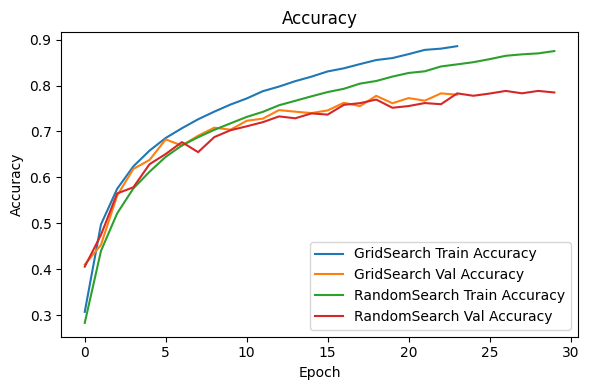

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(grid_hist["loss"], label="GridSearch Train Loss")
plt.plot(grid_hist["val_loss"], label="GridSearch Val Loss")
plt.plot(rand_hist["loss"], label="RandomSearch Train Loss")
plt.plot(rand_hist["val_loss"], label="RandomSearch Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()

plt.figure(figsize=(6,4))
plt.plot(grid_hist["accuracy"], label="GridSearch Train Accuracy")
plt.plot(grid_hist["val_accuracy"], label="GridSearch Val Accuracy")
plt.plot(rand_hist["accuracy"], label="RandomSearch Train Accuracy")
plt.plot(rand_hist["val_accuracy"], label="RandomSearch Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()

plt.show()